In [1]:
import wandb
from datetime import datetime

In [2]:
lr = 1e-3
batch_size = 32
wd = 1e-5
image_size = 512
backbone='efficientdetv2_ds'
vertical_type = "axial"
train_portion = 0.5
# milestones = [10,20,30,40]
model_name = "effdet"
epochs =100

In [3]:
wandb_entity='longyi'
model_name = "effdet"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "backbone" : backbone,
    "image_size" : image_size,
})
wandb.run.name = f'axial_detection_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


'axial_detection_effdet_001015'

In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold



# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95')

In [6]:
boundary_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_axial_boundary_from_axial_seg.csv')).set_index('UID')
boundary_df[['xmin','ymin','xmax','ymax']] = 2 * boundary_df[['xmin','ymin','xmax','ymax']]
print(len(boundary_df))
boundary_df.head()

76908


,xmin,ymin,xmax,ymax,pixel_spacing,axial_index
UID,,,,,,
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,0
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,1
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,2
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,3
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,4


In [7]:
bbox_df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv')).set_index('UID')
print(len(bbox_df))

bbox_df = bbox_df.loc[bbox_df.index.isin(boundary_df.index)]
print(len(bbox_df))
bbox_df.head()

7203
7160


,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [8]:
num_slice_df = bbox_df[["axial_index", "num_slices"]].reset_index().drop_duplicates(subset=['UID']).set_index('UID')
num_slice_df.head()

,axial_index,num_slices
UID,,
1.2.826.0.1.3680043.10051,132,272
1.2.826.0.1.3680043.10579,77,184
1.2.826.0.1.3680043.10678,117,269
1.2.826.0.1.3680043.10697,125,179
1.2.826.0.1.3680043.10732,59,218


In [9]:
for i in range(len(num_slice_df)):
    s = num_slice_df.iloc[i]
    boundary_df.at[s.name, "num_slices"] = s.num_slices
boundary_df.head()

,xmin,ymin,xmax,ymax,pixel_spacing,axial_index,num_slices
UID,,,,,,,
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,0,272.0
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,1,272.0
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,2,272.0
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,3,272.0
1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,4,272.0


In [10]:
len(boundary_df[boundary_df['num_slices'].isna()])

0

In [11]:
bbox_df["UID_axial_index"] = bbox_df.index + "." + bbox_df["axial_index"].astype('string')
bbox_df = bbox_df.set_index('UID_axial_index')
bbox_df.head()

,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID_axial_index,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.132,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051.133,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051.134,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051.135,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051.136,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [12]:
boundary_df["UID_axial_index"] = boundary_df.index + "." + boundary_df["axial_index"].astype('string')
boundary_df = boundary_df.reset_index().set_index('UID_axial_index')
boundary_df.head()

,UID,xmin,ymin,xmax,ymax,pixel_spacing,axial_index,num_slices
UID_axial_index,,,,,,,,
1.2.826.0.1.3680043.10051.0,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,0,272.0
1.2.826.0.1.3680043.10051.1,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,1,272.0
1.2.826.0.1.3680043.10051.2,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,2,272.0
1.2.826.0.1.3680043.10051.3,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,3,272.0
1.2.826.0.1.3680043.10051.4,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0,0.253906,4,272.0


Pick useful columns

In [13]:
total_df = pd.concat((bbox_df[['x','y','width','height']], boundary_df[['xmin','ymin','xmax','ymax','axial_index','UID', 'num_slices']]), axis=1)
print(len(total_df))
total_df.head()

76908


,x,y,width,height,xmin,ymin,xmax,ymax,axial_index,UID,num_slices
UID_axial_index,,,,,,,,,,,
1.2.826.0.1.3680043.10051.132,219.27715,216.71419,17.30440,20.38517,31.076729,0.0,424.923271,393.846542,132,1.2.826.0.1.3680043.10051,272.0
1.2.826.0.1.3680043.10051.133,221.56460,216.71419,17.87844,25.24362,32.076729,0.0,425.923271,393.846542,133,1.2.826.0.1.3680043.10051,272.0
1.2.826.0.1.3680043.10051.134,216.82151,221.62546,27.00959,26.37454,31.076729,0.0,424.923271,393.846542,134,1.2.826.0.1.3680043.10051,272.0
1.2.826.0.1.3680043.10051.135,214.49455,215.48637,27.92726,37.51363,32.076729,0.0,425.923271,393.846542,135,1.2.826.0.1.3680043.10051,272.0
1.2.826.0.1.3680043.10051.136,214.00000,215.48637,27.00000,43.51363,31.076729,0.0,424.923271,393.846542,136,1.2.826.0.1.3680043.10051,272.0


In [14]:
total_df.loc['1.2.826.0.1.3680043.10051.132']

x                              219.27715
y                              216.71419
width                            17.3044
height                          20.38517
xmin                           31.076729
ymin                                 0.0
xmax                          424.923271
ymax                          393.846542
axial_index                          132
UID            1.2.826.0.1.3680043.10051
num_slices                         272.0
Name: 1.2.826.0.1.3680043.10051.132, dtype: object

In [15]:
total_df.iloc[0]

x                              219.27715
y                              216.71419
width                            17.3044
height                          20.38517
xmin                           31.076729
ymin                                 0.0
xmax                          424.923271
ymax                          393.846542
axial_index                          132
UID            1.2.826.0.1.3680043.10051
num_slices                         272.0
Name: 1.2.826.0.1.3680043.10051.132, dtype: object

In [16]:
# total_df.to_csv(os.path.join(DATA_DIR, 'axial_bbox_with_boundary.csv'))

Only pick same size negative cases

In [17]:
neg_count = len(total_df[total_df['x'].isna()])
neg_count

69748

In [18]:
pos_count = len(total_df[~total_df['x'].isna()])
pos_count

7160

In [19]:
len(total_df[total_df['num_slices'].isna()])

0

In [20]:
neg_df = total_df[total_df['x'].isna()]
pos_df = total_df[~total_df['x'].isna()]

In [21]:
neg_df.loc['1.2.826.0.1.3680043.17787.12']

x                                    NaN
y                                    NaN
width                                NaN
height                               NaN
xmin                                 0.0
ymin                                 0.0
xmax                               512.0
ymax                               512.0
axial_index                           12
UID            1.2.826.0.1.3680043.17787
num_slices                         229.0
Name: 1.2.826.0.1.3680043.17787.12, dtype: object

In [22]:
def crop_image(img:Image, bbox, crop_box):
    """

    :param img:
    :param bbox: [left, top, right, bottom]
    :param crop_box:[left, top, right, bottom]
    :return:
    """
    left, top, right, bottom = crop_box
    img = img.crop(crop_box)
    bbox[0] -= left
    bbox[1] -= top
    bbox[2] -= left
    bbox[3] -= top

    return img, bbox

x                                  238.0
y                                  224.0
width                           97.22287
height                          77.30973
xmin                               201.0
ymin                               185.0
xmax                               361.0
ymax                               345.0
axial_index                           74
UID            1.2.826.0.1.3680043.13374
num_slices                         352.0
Name: 1.2.826.0.1.3680043.13374.74, dtype: object


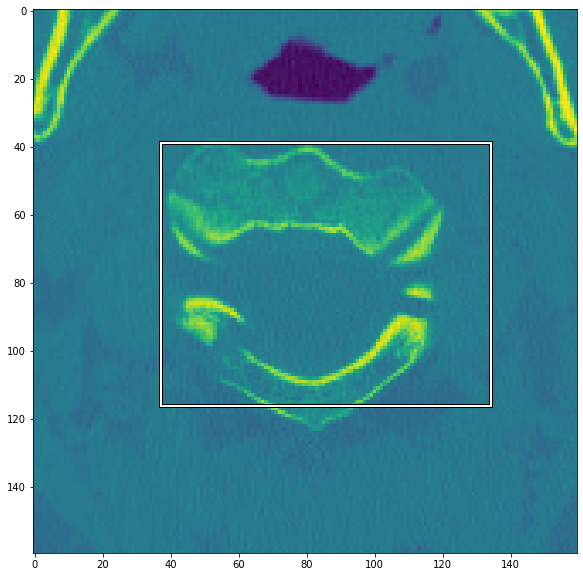

In [23]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()


s = pos_df.iloc[870]
print(s)
image = Image.open(os.path.join(IMAGES_DIR, s.UID, f'{int(s.axial_index)}.jpeg'))
bbox = list(s[['x', 'y','width','height']])
bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
crop_box = s[['xmin','ymin','xmax','ymax']]
image, bbox = crop_image(image, bbox, crop_box)
show_image(image, bbox)

## Dataset

In [24]:
class FractureDatasetAdaptor(Dataset):
    def __init__(self, images_dir_path, pos_df, neg_df):
        self.image_dir = images_dir_path
        self.pos_df = pos_df
        self.neg_df = neg_df

    def __len__(self) -> int:
        return len(self.pos_df) * 2

    def get_image_and_labels_by_idx(self, idx):
        
        is_pos = (idx % 2) == 0
        
        if is_pos:
            s = self.pos_df.iloc[idx // 2]
        else:
            rand_idx = np.random.randint(0, len(self.neg_df))
            s = self.neg_df.iloc[rand_idx]
            # print(s)
        # img = Image.open(os.path.join(self.images_dir_path, s['StudyInstanceUID'], f"{s['axial_index']}.jpeg"))
        # print(s)
        UID = s.UID
        # print(s)
        slice = int(s['axial_index'])
        r = Image.open(os.path.join(self.image_dir, UID, f"{max(0, slice-1)}.jpeg"))
        g = Image.open(os.path.join(self.image_dir, UID, f"{slice}.jpeg"))
        b = Image.open(os.path.join(self.image_dir, UID, f"{min(int(s.num_slices-1), slice+1)}.jpeg"))
        img = Image.merge('RGB', (r, g, b))
        
        if pd.isna(s.x):
            pascal_bboxes = []
            class_labels = []
        else:
            pascal_bboxes = [[s.x, s.y, s.x + s.width, s.y + s.height]]
            class_labels = np.ones(1)

        crop_box = s[['xmin','ymin','xmax','ymax']].values
        return img, pascal_bboxes, class_labels, idx, crop_box

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes)
        print(class_labels)

da = FractureDatasetAdaptor(IMAGES_DIR, pos_df, neg_df)
len(da)
da.get_image_and_labels_by_idx(271)

(<PIL.Image.Image image mode=RGB size=512x512 at 0x7F66BA84F580>,
 [],
 [],
 271,
 array([49.43834435182523, 12.438344351825236, 498.5616556481748,
        461.5616556481748], dtype=object))

## Transform

{'bboxes': tensor([[290.8227, 122.6120, 357.7094, 189.6752]]), 'labels': tensor([1.], dtype=torch.float64), 'image_id': tensor([270]), 'img_size': (512, 512), 'img_scale': tensor([1.])}
tensor(-1.) tensor(0.8532)


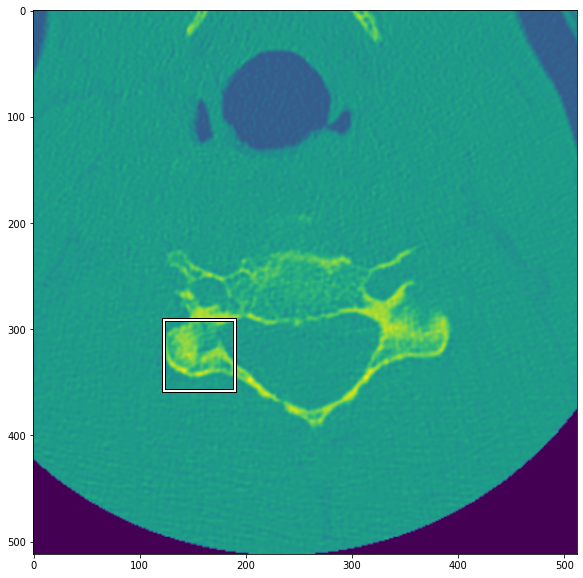

In [25]:
def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.ShiftScaleRotate(p=0.5, rotate_limit=15),
            # A.RandomBrightnessContrast(brightness_limit=0.01,contrast_limit=0.01, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


class EfficientDetDataset(Dataset):
    def __init__(
            self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
            crop_box
        ) = self.ds.get_image_and_labels_by_idx(index)

        if len(pascal_bboxes) > 0:
            image, pascal_bboxes = crop_image(image, pascal_bboxes[0], crop_box)
            pascal_bboxes[0] = max(0, pascal_bboxes[0])
            pascal_bboxes[1] = max(0, pascal_bboxes[1])
            pascal_bboxes[2] = min(image.width, pascal_bboxes[2])
            pascal_bboxes[3] = min(image.height, pascal_bboxes[3])
            
            sample = {
                "image": np.array(image, dtype=np.float32),
                "bboxes": [pascal_bboxes],
                "labels": class_labels,
            }
            sample = self.transforms(**sample)
            sample["bboxes"] = np.array(sample["bboxes"])
            image = sample["image"]
            labels = sample["labels"]

            # print(sample)

            _, new_h, new_w = image.shape
            if len(sample["bboxes"]) > 0:
                sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
                                                :, [1, 0, 3, 2]
                                                ]  # convert to yxyx

                target = {
                    "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
                    "labels": torch.as_tensor(labels),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
            else:
                target = {
                    "bboxes": torch.zeros((0, 4)),
                    "labels": torch.tensor([]),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
        else:
            image = image.crop(crop_box)   
            image = self.transforms(image=np.array(image, dtype=np.float32), bboxes=[], labels=[])["image"]
            _, new_h, new_w = image.shape
            target = {
                "bboxes": torch.zeros((0, 4)),
                "labels": torch.tensor([]),
                "image_id": torch.tensor([image_id]),
                "img_size": (new_h, new_w),
                "img_scale": torch.tensor([1.]),
            }
        
        

        return image, target, image_id

    def __len__(self):
        return len(self.ds)


train_dataset = EfficientDetDataset(da, transforms=get_train_transforms())
img, ann, idx = train_dataset[270]
print(ann)
print(img.min(), img.max())
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img[0, :, :])

if len(ann['bboxes']) > 0:
    draw_pascal_voc_bboxes(ax, ann['bboxes'][0].cpu().numpy()[[1, 0, 3, 2]])


In [26]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

In [27]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=min(os.cpu_count(), 16),
    collate_fn=collate_fn,
)

## Model

In [28]:
from effdet.config.model_config import efficientdet_model_param_dict
list(efficientdet_model_param_dict.keys())

['efficientdet_d0',
 'efficientdet_d1',
 'efficientdet_d2',
 'efficientdet_d3',
 'efficientdet_d4',
 'efficientdet_d5',
 'efficientdetv2_dt',
 'efficientdetv2_ds',
 'resdet50',
 'cspresdet50',
 'cspresdext50',
 'cspresdext50pan',
 'cspdarkdet53',
 'cspdarkdet53m',
 'mixdet_m',
 'mixdet_l',
 'mobiledetv2_110d',
 'mobiledetv2_120d',
 'mobiledetv3_large',
 'efficientdet_q0',
 'efficientdet_q1',
 'efficientdet_q2',
 'efficientdet_w0',
 'efficientdet_es',
 'efficientdet_em',
 'efficientdet_lite0',
 'tf_efficientdet_d0',
 'tf_efficientdet_d1',
 'tf_efficientdet_d2',
 'tf_efficientdet_d3',
 'tf_efficientdet_d4',
 'tf_efficientdet_d5',
 'tf_efficientdet_d6',
 'tf_efficientdet_d7',
 'tf_efficientdet_d7x',
 'tf_efficientdet_d0_ap',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d2_ap',
 'tf_efficientdet_d3_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_d5_ap',
 'tf_efficientdet_lite0',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite2',
 'tf_efficientdet_lite3',
 'tf_efficientdet_lite3x',
 'tf_ef

In [29]:
from effdet import create_model
model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

26374778


In [30]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

In [31]:
# images = torch.randn(2, 3, 512, 512).to(device)
# anns = {
#     'bbox' : [torch.randn((0, 4)).to(device), torch.randn((0, 4)).to(device)],
#     'cls' : [torch.tensor([]).to(device), torch.tensor([]).to(device)],
#     'image_size' : torch.ones((2, 2)).to(device) * 512.,
#     'img_scale' : torch.ones(2).to(device)
# }
# print(anns)
# loss_dict = model(images, anns)

# optimizer.zero_grad()
# loss_dict['loss'].backward()
# optimizer.step()

# loss_dict['loss'].item()

In [32]:
# images, anns, _, image_ids = next(iter(train_loader))
# print(anns)
# print(images.shape)
# images = images.to(device)
# anns = {
#     'bbox' : [tensor.to(device) for tensor in anns['bbox']],
#     'cls' : [tensor.to(device) for tensor in anns['cls']],
#     'img_size' : anns['img_size'].to(device),
#     'img_scale' : anns['img_scale'].to(device)
# }
# model(images, anns)

In [33]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))

In [34]:
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

## Train one epoch

In [35]:
def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    loss_list = []
    epoch_iteration = len(dataloader)

    for i, (images, anns, _, _) in enumerate(train_iter):
        images = images.to(device)
        anns = {
            'bbox' : [tensor.to(device) for tensor in anns['bbox']],
            'cls' : [tensor.to(device) for tensor in anns['cls']],
            'img_size' : anns['img_size'].to(device),
            'img_scale' : anns['img_scale'].to(device)
        }

        with torch.cuda.amp.autocast(device == 'cuda'):
            losses = model(images, anns)
            loss, class_loss, box_loss = losses['loss'], losses['class_loss'], losses['box_loss']

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step(e + i / epoch_iteration)

        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {class_loss.item():.4f} b {box_loss.item():.4f}")

        loss_list.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'train_class_loss': class_loss.item(),
                'train_box_loss': box_loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })

        # if i % 100 == 0:
        #     with torch.no_grad():
        #         inference(model, val_dataset)
        #         # infer_bad_sample(wandb_log=True)
        #     model.train()

    return np.mean(loss_list)

In [36]:
def save_state(epoch):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))


In [37]:
epoch = 0

In [ ]:
for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)

    # with torch.no_grad():
    #     evaluate(epoch, model, val_loader)


    epoch += 1
    scheduler.step()
    
    if epoch % 10 == 0:
        save_state(epoch)

t 161 loss 0.0835 c 0.0670 b 0.0003: 100%|█████████▉| 446/447 [06:03<00:00,  1.25it/s]

In [ ]:
save_state(epoch)